In [1]:
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch.nn.functional import cosine_similarity
from evaluate import load
from sentence_transformers import SentenceTransformer

## Evaluate & Plot

In [2]:
bertscore = load("bertscore")

In [8]:
llama2_df = pd.read_csv('./data/eval-Llama2.csv')
llama3_df = pd.read_csv('./data/eval-llama3.csv')
gemma_df = pd.read_csv('./data/eval-gemma.csv')
mistral_df = pd.read_csv('./data/eval-Mistral.csv')

In [9]:
def get_bertscore(df):

    combined = {}
    for shot in ['zero-shot', 'one-shot', 'five-shot']:
        results = bertscore.compute(predictions=df[shot],
                                    references=df['explanation'],
                                    lang='en')
        results.pop('hashcode', None)
        [combined.update({f"{shot}-{k}": v}) for k, v in results.items()]

    return pd.DataFrame(combined)


def sentence_transformer_score(df, model_name):

    model = SentenceTransformer(model_name)
    true_embedding = model.encode(df['explanation'].values,
                                  convert_to_tensor=True)
    combined = {}
    for shot in ['zero-shot', 'one-shot', 'five-shot']:
        combined[shot] = cosine_similarity(
            true_embedding,
            model.encode(df[shot].values,
                         convert_to_tensor=True)).flatten().cpu().numpy()

    return pd.DataFrame(combined)

In [4]:
df_ls = [llama2_df, llama3_df, gemma_df, mistral_df]

In [18]:
# berscore
results = list(map(get_bertscore, df_ls))

In [18]:
# SentenceTransformer
results = list(
    map(
        lambda x: sentence_transformer_score(
            x, 'sentence-transformers/all-mpnet-base-v2'), df_ls))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

d:\Program\miniconda3\envs\DL\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [2]:
shots = ['zero-shot', 'one-shot', 'five-shot']
categories = ['Llama2', 'Llama3', 'Gemma', 'Mistral']

In [19]:
with pd.ExcelWriter('./eval/all-mpnet-base-v2.xlsx',
                    engine='xlsxwriter') as writer:
    for df, sheet_name in zip(results, categories):
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [ ]:
# bertscore
shot_mean = {
    shot: [df[f'{shot}-f1'].mean() for df in results]
    for shot in shots
}
shot_full = {shot: [df[f'{shot}-f1'] for df in results] for shot in shots}

In [20]:
# SentenceTransformer
shot_full = {shot: [df[shot] for df in results] for shot in shots}

In [3]:
bar_width = 0.2
bar_pos = [
    np.arange(len(categories)) + i * bar_width for i in range(len(shots))
]

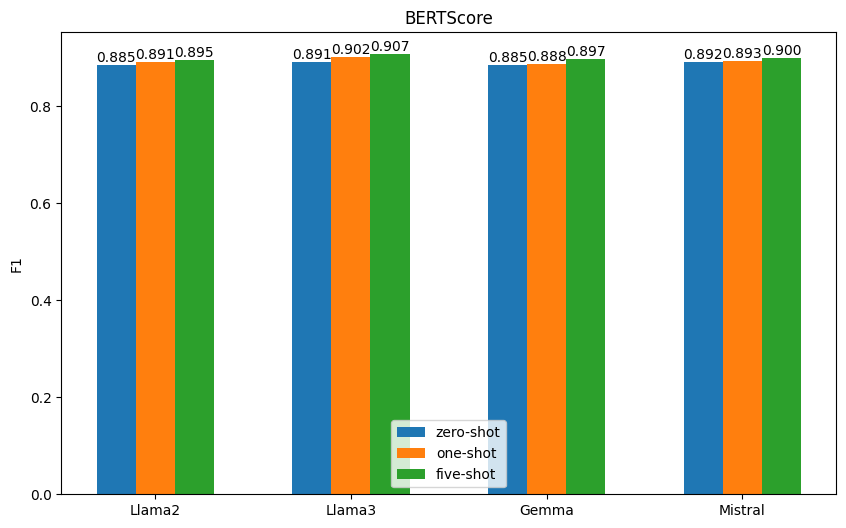

In [72]:
plt.figure(figsize=(10, 6))
for i in range(len(shots)):
    plt.bar(bar_pos[i], shot_mean[shots[i]], bar_width, label=shots[i])
    _ = [
        plt.text(bar_pos[i][j],
                 shot_mean[shots[i]][j],
                 f"{shot_mean[shots[i]][j]:.3f}",
                 ha='center',
                 va='bottom') for j in range(len(categories))
    ]
plt.xticks(bar_pos[0] + bar_width, categories)
plt.ylabel('F1')
plt.title('BERTScore')
plt.legend()

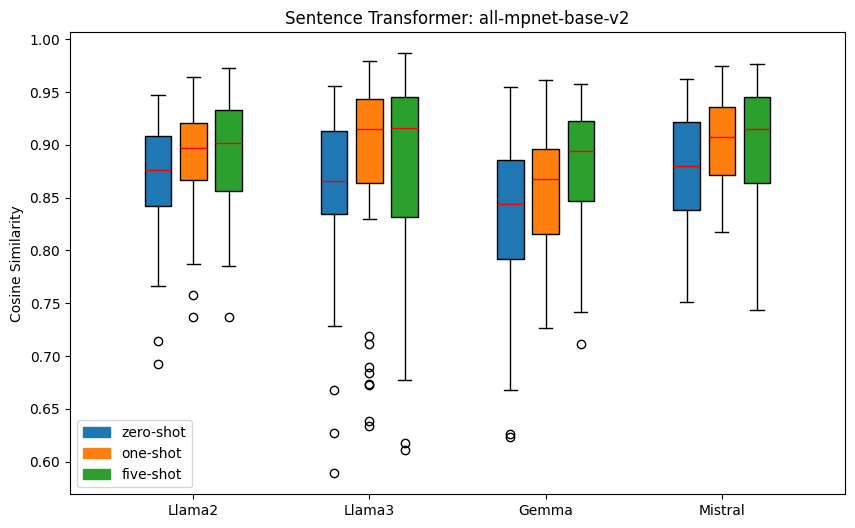

In [21]:
plt.figure(figsize=(10, 6))
legend_patches = []
for i in range(len(shots)):
    plt.boxplot(shot_full[shots[i]],
                positions=bar_pos[i],
                widths=0.15,
                patch_artist=True,
                boxprops=dict(facecolor=f'C{i}'),
                medianprops=dict(color='red', linestyle='-', linewidth=1))
    legend_patches.append(mpatches.Patch(color=f'C{i}', label=shots[i]))

plt.xticks(bar_pos[0] + bar_width, categories)
plt.ylabel('Cosine Similarity')
plt.title('Sentence Transformer: all-mpnet-base-v2')
plt.legend(handles=legend_patches)
plt.savefig('./eval/all-mpnet-base-v2.png')
plt.show()

In [16]:
scores = pd.read_excel('./eval/human_eval_scores.xlsx', sheet_name=None)

In [17]:
shot_mean = {
    shot: [df[shot].mean() for df in scores.values()]
    for shot in shots
}

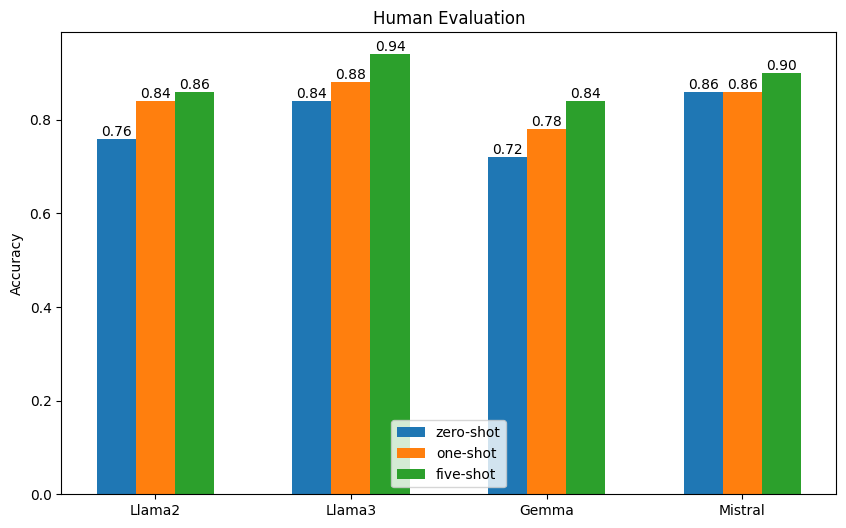

In [8]:
plt.figure(figsize=(10, 6))
for i in range(len(shots)):
    plt.bar(bar_pos[i], shot_mean[shots[i]], bar_width, label=shots[i])
    _ = [
        plt.text(bar_pos[i][j],
                 shot_mean[shots[i]][j],
                 f"{shot_mean[shots[i]][j]:.2f}",
                 ha='center',
                 va='bottom') for j in range(len(categories))
    ]
plt.xticks(bar_pos[0] + bar_width, categories)
plt.ylabel('Accuracy')
plt.title('Human Evaluation')
plt.legend(loc="lower center")
plt.savefig('./eval/human_eval.png')

## Latex Tables

In [9]:
bertscore_dfs = pd.read_excel('./eval/bertscore.xlsx', sheet_name=None)
minilm_dfs = pd.read_excel('./eval/all-MiniLM-L6-v2.xlsx', sheet_name=None)
mpnet_dfs = pd.read_excel('./eval/all-mpnet-base-v2.xlsx', sheet_name=None)

In [29]:
median_table = defaultdict(list)

for shot in shots:
    for key in categories:
        median_table['shot'].append(shot.split('-')[0])
        median_table['model'].append(key)

        median_table['Bertscore F1'].append(
            bertscore_dfs[key][f'{shot}-f1'].median())
        median_table['Sentence Transformer: all-MiniLM-L6-v2'].append(
            minilm_dfs[key][shot].median())
        median_table['Sentence Transformer: all-mpnet-base-v2'].append(
            mpnet_dfs[key][shot].median())

In [30]:
median_df = pd.DataFrame(median_table).set_index(['shot', 'model'])

In [32]:
median_df.to_latex('./eval/median_table.tex')

In [33]:
median_df.to_csv('./eval/median_table.csv')

In [10]:
hv_df = pd.DataFrame(shot_mean)
hv_df.index = categories

In [13]:
hv_df.to_latex('./eval/human_eval_table.tex')

,zero-shot,one-shot,five-shot
Llama2,0.76,0.84,0.86
Llama3,0.84,0.88,0.94
Gemma,0.72,0.78,0.84
Mistral,0.86,0.86,0.90


In [11]:
hv_df.to_csv('./eval/human_eval_table.csv')